# How to appropriately calculate frequency spectra? (work in progress)

With this notebook I want to show how to calculate windowed frequency (or wavenumber) spectra using python in a way that conserve the energy of your original signal. We import the `numpy` module that contains function to calculate Fourier transforms, as well as `xrft` which applies FFT to xarray objects. The `scipy.signal` module is used to generate the windows or tapers.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss 
import pandas
import xarray as xr
import xrft

We generate a random complex time series. Optionally, we make it "red" in character by taking the cumulative sum but removing the strong linear trend

In [10]:
dt = 1/24 # define the time step in units of days
N = 1440 # Number of time step, i.e. 60 days 
#u = 0.1*np.random.randn(1440).cumsum(axis=0)
#v = 0.1*np.random.randn(1440).cumsum(axis=0)
u = 0.1*np.random.randn(N)
v = 0.1*np.random.randn(N)
#z = ss.detrend(u+1j*v);
z = u+1j*v;
#z = u;

Also make a xarray object of dimension time of 1440 hours, using pandas and xarray. This object will be used by `xrft`

In [40]:
time = pandas.date_range(start='1/1/2014 01:00:00',end='3/2/2014 00:00:00',freq='H')
#time = np.arange(0,1440)
#time = datetime.time?
za = xr.Dataset({'z': (['time'],z)},coords={'time':time})
#  I do not understand the time unit in pandas. Is it in nanoseconds? but xrft understands it in seconds?
foo=za.time[0]-za.time[1]
foo

<xarray.DataArray 'time' ()>
array(-3600000000000, dtype='timedelta64[ns]')

Make a plot of the components of z

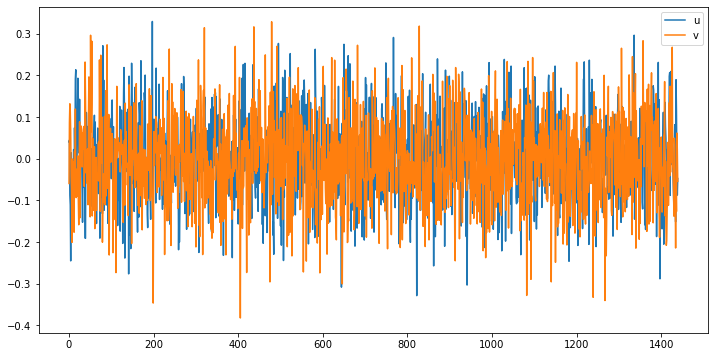

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 6))
h1, = plt.plot(z.real)
h2, = plt.plot(z.imag)
plt.legend([h1,h2],['u','v'])

We define a frequency axis using the `fftfreq` function from `numpy.fft`. We also define windows or tapers that have "unit energy", i.e. $\sum_i w_i^2=1$


In [44]:
f = np.fft.fftfreq(z.shape[0],dt) # define frequency scale/abscissa, dt is in units of days

# define a rectangular window, or boxcar, with unit energy
foo = np.ones(z.shape[0])
boxcar_fac = np.square(foo).sum()
wr = foo/np.sqrt(boxcar_fac)

# define a Hann  window with unit energy
foo = np.hanning(z.shape[0])
hann_fac = np.square(foo).sum()
wh = foo/np.sqrt(hann_fac)

# define a Slepian window with unit energy
foo = ss.windows.dpss(z.shape[0],3)
slepian_fac = np.square(foo).sum()
ws = foo/np.sqrt(slepian_fac)

# verify that the windows are both unit energy
print('boxcar window, sum of w^2:', sum(np.square(wr)))
print('Hann window, sum of w^2:', sum(np.square(wh)))
print('Slepian window, sum of w^2:', sum(np.square(ws)))

# correcting factors
print('Boxcar constant:', boxcar_fac)
print('Hann constant:', hann_fac)
print('Slepian constant:', slepian_fac)

boxcar window, sum of w^2: 0.9999999999999967
Hann window, sum of w^2: 1.0000000000000013
Slepian window, sum of w^2: 0.9999999999999992
Boxcar constant: 1440.0
Hann constant: 539.625
Slepian constant: 425.00717267611924


Is `z` zero-mean? Maybe not exactly

In [48]:
# How to display JUST the value?
display(za.z.mean())

<xarray.DataArray 'z' ()>
array(0.00166983-0.0039548j)

Now let's calculate spectral estimates. We form the following quantity:
$$ S^{(d)}_n = \Delta t \left| \sum_{k=0}^{N-1} h_k x_k e^{-i 2 \pi n k /N}\right|^2 = \Delta t\, |\texttt{DFT(xh)}_n|^2,$$
which practically means that we have now applied a FFT to the sequence $x_k h_k$. $h_k$ is a window or taper sequence which is used to improve our spectral estimates by reducing their variance. In the expression above, $\texttt{DFT(x)}_n = \sum_{k=0}^{N-1} x_t e^{i2\pi n k/N} $ with  $n=0 \ldots N-1$, is the $N$-long sequence that Matlab and python numpy returns with the function $\texttt{fft}$,  which also implies that the Matlab and python convention is $\Delta t = 1$.

Now the frequency integral of $S^{(d)}_n$, in discrete form, can be shown to be (after some math, see [Percival and Walden 1993](https://books.google.com/books?hl=en&lr=&id=FubniGJ0ECQC&oi=fnd&pg=PR15&dq=percival+and+walden+1993&ots=mvIeL7vAJT&sig=uymCuxMP8Cjcy0g-hK12ipqQwzM)):

$$\frac{1}{N \Delta t}  \sum_{n=0}^{N-1} S_n^{(d)} = \frac{1}{N}\sum_{k=0}^{N-1} |x_k|^2 \sum_{k=0}^{N-1}h_k^2.$$


If we make sure that the windows are unit energy (normalized), so that $\sum_{k=0}^{N-1}h_k^2=1$, then we verify the Parseval's theorem which interpretation is that the frequency integral of spectrum is equal to the variance estimate of the original signal, if $x_k$ is zero mean. If $x_k$ is not zero mean, this is still applicable and the integral of the spectrum is just the sum of the squared values of the sequence $x_k$. For the zero mean case, we have:
$$ \frac{1}{N \Delta t} \sum_{n=0}^{N-1} S_n^{(d)} = \frac{1}{N} \sum_{k=0}^{N-1} |x_k|^2 \equiv \text{Var}(x).$$

In conclusion, $S^{(d)}_n = \Delta t\, |\texttt{DFT(xh)}_n|^2$ is our estimate of the Power Spectral Density or PSD as a function of Fourier frequencies $f_n = n/N\Delta t$. Now, in practice:


In [79]:
# Applying the boxcar window, normalized. Also remove the mean of the input
zfft1 = np.fft.fft((z-np.mean(z))*wr) # FFT
szz1 = (np.abs(zfft1)**2)*dt
# szz1 = dt*zfft.conj()*zfft # this should be equivalent to above but does not return a real quantity

# Applying the Hann window, normalized
zfft2 = np.fft.fft((z-np.mean(z))*wh) # FFT
szz2 = (np.abs(zfft2)**2)*dt

# Using xrft routine for FFT with no window. `xrft.dft` does not normalize properly even in the absence of windowing
zfft3 = xrft.dft(za.z,dim=['time'],window=False,detrend='constant',shift=False)
# multiply the absolute squared Fourier transform coefficients by dt to make a PSD and divide by correction for window
szz3 = (np.abs(zfft3)**2)*dt/(boxcar_fac)

# Using `xrft.dft` routine for FFT but with Hann window. `xrft.dft` does not normalize properly, even with a window
zfft4 = xrft.dft(za.z,dim=['time'],window=True,detrend='constant',shift=False)
# multiply the absolute squared Fourier transform coefficients by dt to make a PSD and divide by correction for window
szz4 = (np.abs(zfft4)**2)*dt/hann_fac 

# Applying a Slepian window, normalized
zfft5 = np.fft.fft((z-np.mean(z))*wr) # FFT
szz5 = (np.abs(zfft5)**2)*dt

# Using the `xrft.power_spectrum method` with the density option, which divides by N^2 and the frequency spacing 1/(N dt) with dt in s?
# It calculates the frequency spacing using np.fftfreq using the diff of the dimension 
# to correct, I multiply back by N^2 and 1/(N dt) as well as correct by the dt/hann_fac
szz6 = (dt/hann_fac)*(1/(N*60*60))*N**2*xrft.power_spectrum(za.z,dim=['time'],window=True,detrend='constant',shift=False,density=True)

Let's verify that the integrals of the spectra equal approximately the variance, i.e. Parseval's theorem

In [80]:
print('var z:',np.var(z,dtype=np.float64,ddof=1)) 

print('Integral of Szz1:', szz1.sum()*f[1])
print('Integral of Szz2:', szz2.sum()*f[1])
print('Integral of Szz3:', szz3.sum()*f[1])
print('Integral of Szz4:', szz4.sum()*f[1])
print('Integral of Szz5:', szz5.sum()*f[1])
print('Integral of Szz6:', szz6.sum()*f[1])


var z: 0.02107760359299626
Integral of Szz1: 0.02104732591852676
Integral of Szz2: 0.02155488051342682
Integral of Szz3: <xarray.DataArray ()>
array(0.02104733)
Coordinates:
    freq_time_spacing  float64 1.929e-07
Integral of Szz4: <xarray.DataArray ()>
array(0.02155488)
Coordinates:
    freq_time_spacing  float64 1.929e-07
Integral of Szz5: 0.02104732591852676
Integral of Szz6: <xarray.DataArray ()>
array(0.02155488)
Coordinates:
    freq_time_spacing  float64 1.929e-07


/Users/selipot/opt/anaconda3/envs/rces/lib/python3.7/site-packages/numpy/core/_methods.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


Make a figure after making NaN the zero frequency band for legibility

(-1.0, 1.0)

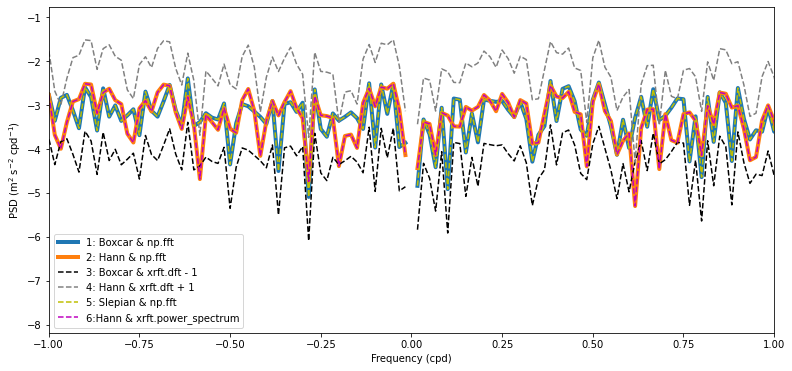

In [84]:
szz1[0] = np.nan
szz2[0] = np.nan
szz3[0] = np.nan
szz4[0] = np.nan
szz5[0] = np.nan
szz6[0] = np.nan

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
h1, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz1)),scaley=True,linewidth=4)
# here I am not sure why I have to take the real part. szz should be real
h2, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz2)),scaley=True,linewidth=4)
h3 , = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz3)-1),scaley=True,linestyle='dashed',color='k')
h4, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz4)+1),scaley=True,linestyle='dashed',color='0.5')
h5, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz5)),scaley=True,linestyle='dashed',color='y')
h6, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz6)),scaley=True,linestyle='dashed',color='m')

plt.legend([h1,h2,h3,h4,h5,h6], ['1: Boxcar & np.fft','2: Hann & np.fft','3: Boxcar & xrft.dft - 1','4: Hann & xrft.dft + 1','5: Slepian & np.fft','6:Hann & xrft.power_spectrum'])
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xlabel('Frequency (cpd)')

ax.set_xlim(xmin=-1, xmax=1)
#ax.set_ylim(ymin=-6, ymax=0)

In conclusion, all the estimates agree after applying the proper normalization and correcting factors for `xrft`